# 🌾 Agricultural Pests Classification using Deep Convolutional Neural Networks and Transfer Learning

### 👋 Welcome to My Notebook!

Thank you for visiting! 🌟 If you find this notebook helpful, please consider upvoting it. Your support not only motivates me but also helps others discover my work. Feel free to fork or edit this notebook for your convenience.

### 🔬 Overview

Pest image classification is a cutting-edge technology that harnesses the power of machine learning algorithms to detect and identify pests in agricultural fields. This innovative approach has gained traction in recent years, driven by the growing demand for sustainable agriculture practices and the need to minimize the use of chemical pesticides.

#### 🌱 Benefits of Pest Image Classification:
- **Environmental Friendly:** Reduces reliance on chemical pesticides, mitigating their negative impacts on both the environment and human health.
- **Enhanced Crop Management:** Facilitates timely interventions, potentially preventing crop losses and boosting overall yield and productivity.
- **Cost Efficiency:** Lowers labor costs by automating the pest detection and classification process, making pest management more efficient.

#### 🚀 Technological Advancements and Challenges:
- **Data Requirements:** The effectiveness of classification systems heavily relies on extensive datasets composed of high-quality images of both pests and non-pests.
- **Image Variability:** Factors like varying lighting conditions and camera angles can affect the consistency of pest images, posing challenges to classification accuracy.
- **Innovative Solutions:** To address these challenges, researchers are turning to solutions like transfer learning, data augmentation, and the integration of multiple sensors for robust data collection.

In conclusion, pest image classification represents a promising frontier in agricultural technology. It offers significant potential to revolutionize pest management practices, promoting sustainable agriculture by reducing chemical use, enhancing yields, and cutting labor costs. As this technology evolves, it promises to play a pivotal role in transforming agricultural pest management.
# -------------
#### Author : Sai Bhaskar Kumptla

In [ ]:
!unzip /content/drive/MyDrive/Assignments/agriculture_pests_reduced.zip -d /content/agriculture_pests_reduced

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
# Basic data handling and numerical operations
import numpy as np
import pandas as pd
import os
import shutil
import glob
import math
import random
from pathlib import Path
import itertools

# Machine Learning and Data Processing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks,Model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetB4
from tensorflow.keras.layers.experimental import preprocessing
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import warnings
# Set visual and warning preferences
warnings.filterwarnings('ignore')



In [ ]:
# HELPER FUNCTIONS

def eval_model(model, test_dataset):
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    predictions = model.predict(test_dataset)
    predicted_class_indices = np.argmax(predictions, axis=1)
    true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    true_class_indices = np.argmax(true_labels, axis=1)
    cm = confusion_matrix(true_class_indices, predicted_class_indices)
    print("Confusion Matrix:")
    print(cm)
    return cm, test_accuracy * 100

def generate_report(model,test_dataset):
  predictions = model.predict(test_dataset)
  predicted_class_indices = np.argmax(predictions, axis=1)
  true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
  true_class_indices = np.argmax(true_labels, axis=1)
  report = classification_report(true_class_indices, predicted_class_indices, output_dict=True)
  report = pd.DataFrame(report).transpose()
  if len(categories) == len(report) - 3:
      new_index = categories + ['accuracy', 'macro avg', 'weighted avg']
      report.index = new_index
  return report

In [ ]:
# Paths and category setup
source_dir = '/content/agriculture_pests_reduced/content/agriculture_pests_reduced'
target_dir = '/content/dataset'
categories = ['ants', 'bees', 'beetle','catterpillar','earwig','grasshopper','earthworms','slug','moth','snail','wasp','weevil']
split_ratios = {'train': 0.70, 'validation': 0.15, 'test': 0.15}

# Function to create directory structure
def create_directories(target_base, dataset_categories):
    for dataset_type in ['train', 'validation', 'test']:
        for category in dataset_categories:
            os.makedirs(os.path.join(target_base, dataset_type, category), exist_ok=True)

# Function to copy files to target directories
def copy_files(files_list, target):
    for file in files_list:
        shutil.copy(file, target)

# Function to split and distribute files
def distribute_files(source, destination, categories, split_ratios):
    for category in categories:
        files = []
        for extension in ['*.png', '*.jpg', '*.jpeg']:
            files.extend(glob.glob(os.path.join(source, category, extension)))

        if not files:
            print(f"No files found for category '{category}'. Skipping...")
            continue

        # Calculate split sizes
        total_files = len(files)
        val_size = int(total_files * split_ratios['validation'])
        test_size = int(total_files * split_ratios['test'])
        train_size = total_files - val_size - test_size

        # Split files
        train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_size, random_state=42)

        # Distribute files
        copy_files(train_files, os.path.join(destination, 'train', category))
        copy_files(val_files, os.path.join(destination, 'validation', category))
        copy_files(test_files, os.path.join(destination, 'test', category))


In [ ]:
create_directories(target_dir, categories)
distribute_files(source_dir, target_dir, categories, split_ratios)
print("Data distribution complete.")

Data distribution complete.


## 🛠️ Data Preprocessing
## Getting our data ready for training is a critical step in our machine learning pipeline. 🌿 Here's how we prepare our dataset to ensure our models learn effectively:

## Data Splitting: We meticulously split our images into training, validation, and test sets. This structure helps in training robust models and evaluating their performance on unseen data accurately.
## Image Augmentation: To make our models more robust and prevent overfitting, we apply various image augmentation techniques such as flipping, rotation, and zooming during training. This process introduces variability in the training data without the need for more images.
## Rescaling and Normalization: Each image is rescaled and normalized to ensure that our models receive input data within a standard range, improving the training stability and performance.
## By carefully preparing our data, we set the stage for our models to learn efficiently and perform their best during both training and real-world deployment. 🌍

In [ ]:
root_dir = "/content/dataset"
train_dir = os.path.join(root_dir, 'train')
validation_dir = os.path.join(root_dir, 'validation')
test_dir = os.path.join(root_dir, 'test')

train_dataset = image_dataset_from_directory(
train_dir,
image_size=(224, 224),
label_mode='categorical',
batch_size=32)

validation_dataset = image_dataset_from_directory(
validation_dir,
image_size=(224, 224),
label_mode='categorical',
batch_size=32)

test_dataset = image_dataset_from_directory(
test_dir,
image_size=(224, 224),
batch_size=32,
label_mode='categorical',
shuffle=False)


Found 840 files belonging to 12 classes.
Found 180 files belonging to 12 classes.
Found 180 files belonging to 12 classes.


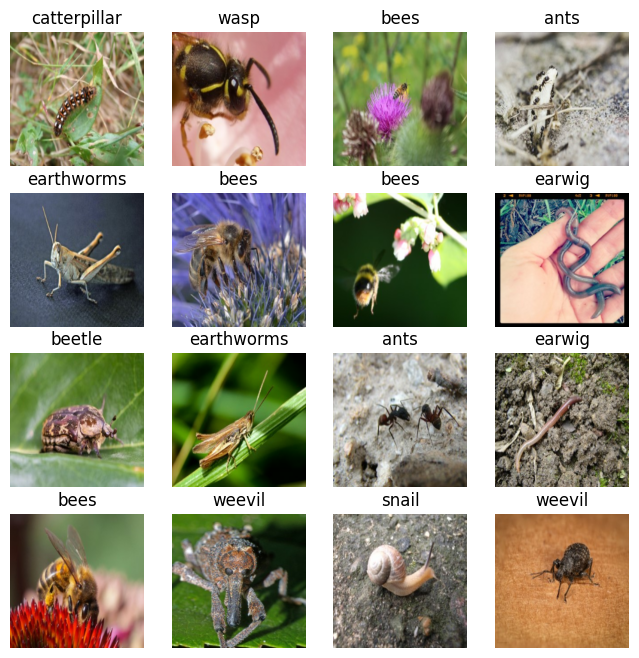

In [ ]:
plt.figure(figsize=(8,8))
for   images,labels in  validation_dataset.take(10):
  for i  in range(16):
   ax=plt.subplot(4,4,i+1)
   plt.imshow(images[i]/255.)
   plt.title(categories[tf.argmax(labels[i],axis=0).numpy()])
   plt.axis("off")

In [ ]:
def data_augmentation(x):
    x = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(x)
    x = layers.experimental.preprocessing.RandomRotation(0.3)(x)
    x = layers.experimental.preprocessing.RandomZoom(0.3)(x)
    x = layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
    return x

def residual_block(x, filter):
  residual = x
  x = layers.SeparableConv2D(filters=filter, kernel_size=3, padding="same", use_bias=False )(x)
  x= layers.BatchNormalization()(x)
  x= layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=filter, kernel_size=3, padding="same", use_bias=False)(x)
  x= layers.BatchNormalization()(x)
  x= layers.ReLU()(x)
  x = layers.SeparableConv2D(filters=filter, kernel_size=3, padding="same", use_bias=False)(x)
  x= layers.BatchNormalization()(x)
  x= layers.ReLU()(x)

  x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
  residual = layers.Conv2D(filters=filter, kernel_size=1, strides=2, use_bias=False)(residual)
  x = layers.add([x, residual])
  return x

# HYPERPARAMETER TUNING USING KERAS TUNER  ( RANDOM SEARCH )

### -- We were able to run for 5 max trails for 100 epochs each as it took approxiamately 40 mins for runnig one loop. 34% was maximum accuracy achevied in tuning process for 100 epochs, hence we took a differnt approach and increased the no of epochs to 200.

In [ ]:
def build_model(hp):
    input_shape = (224, 224, 3)
    input = keras.Input(shape=input_shape)
    x = data_augmentation(input)
    x = layers.experimental.preprocessing.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Tuning the number of filters in residual blocks
    for filter_size in [32, 64, 128, 256, 512]:
        x = residual_block(x, filter=hp.Choice(f'num_filters_{filter_size}', values=[filter_size, filter_size * 2]))

    x = layers.GlobalAveragePooling2D()(x)

    # Tunable dropout rates
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(12, activation="softmax")(x)
    model = keras.Model(inputs=input, outputs=output)

    # Tuning the learning rate
    lr = hp.Choice('learning_rate', values=[0.001, 0.005, 0.0001, 0.0005, 0.00001, 0.00005])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Setting up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Assignments/models/',
    project_name='hparam_tuning'
)

# Callbacks
callbacks = [ tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Assignments/models/pest_detection_tuning", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
]

# Start the hyperparameter tuning
tuner.search(train_dataset,
             validation_data=validation_dataset,
             epochs=100,
             callbacks=callbacks)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optionally, save the best model
best_model.save('/content/drive/MyDrive/Assignments/models/best_model.h5')

Trial 5 Complete [00h 07m 22s]
val_accuracy: 0.30000001192092896

Best val_accuracy So Far: 0.3444444537162781
Total elapsed time: 00h 35m 39s


## 🎯 Training with Three Distinct Models
## In our quest to achieve optimal pest classification, we've employed three diverse deep learning models, each bringing unique strengths to the table. 🤖

## Custom CNN with Data Augmentation: This model is a powerhouse, built from scratch, equipped with data augmentation to enhance its ability to generalize across varied images. By introducing randomized transformations, this model becomes robust against the variability in pest images.
## MobileNet V3 (Transfer Learning): We leverage the power of transfer learning with MobileNet V3, a model pre-trained on ImageNet. This approach accelerates our training process and harnesses learned features applicable to our pest classification task, making it highly efficient and less resource-intensive.
## EfficientNetV2 (Transfer Learning): Lastly, EfficientNetV2 is utilized for its state-of-the-art architecture that scales efficiently with increased computational power. This model has shown remarkable adaptability to our dataset, further refined by transfer learning to achieve impressive accuracy.
## Each model undergoes rigorous training and validation phases, allowing us to compare and understand their performance nuances directly. 🌟 This hands-on approach not only teaches us about the strengths and limitations of each model but also guides us in fine-tuning them for enhanced performance.

# **MODEL 1- TUNED CNN WITH DATA AUGMENTATION AND RESIDUAL BLOCK**

In [ ]:
def get_tuned_model(input_shape, filters):
    input = keras.Input(shape=input_shape)
    x = data_augmentation(input)
    x = layers.experimental.preprocessing.Rescaling(1./255)(x)

    # Increase the number of filters in the initial convolutional layers
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same")(x)  # Increased filters
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters=128, kernel_size=3, padding="same")(x)  # Increased filters
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

    # Process through multiple residual blocks with increased complexity
    for filter_size in filters:  # Adjusted filter sizes for more complexity
        x = residual_block(x, filter_size)

    x = layers.GlobalAveragePooling2D()(x)

    # Increase the complexity in dense layers
    x = layers.Dense(256, activation='relu')(x)  # Increased units
    x = layers.Dropout(0.2)(x)  # Increased dropout rate for regularization
    x = layers.Dense(256, activation='relu')(x)  # Additional dense layer with more units
    x = layers.Dropout(0.2)(x)  # Consistent dropout for additional dense layer

    output = layers.Dense(12, activation="softmax")(x)
    model = keras.Model(inputs=input, outputs=output)
    return model


In [ ]:
optimizer= Adam(learning_rate= 0.001)

# disabling earlystopping as learning starts late
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Assignments/models/tuned_model_logs", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30)
]
tuned_model = get_tuned_model(input_shape=(224, 224, 3), filters=[32, 64, 128,256,512])

tuned_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history_CNN = tuned_model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=200,
                    callbacks=callbacks)

tuned_model.save('/content/drive/MyDrive/Assignments/models/tuned_CNN.h5')

Epoch 1/200
27/27 [==============================] - 49s 935ms/step - loss: 2.6081 - accuracy: 0.1357 - val_loss: 2.4866 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 2/200
27/27 [==============================] - 12s 447ms/step - loss: 2.5014 - accuracy: 0.1405 - val_loss: 2.4840 - val_accuracy: 0.1056 - lr: 0.0010
Epoch 3/200
27/27 [==============================] - 3s 119ms/step - loss: 2.4692 - accuracy: 0.1512 - val_loss: 2.4874 - val_accuracy: 0.0889 - lr: 0.0010
Epoch 4/200
27/27 [==============================] - 3s 118ms/step - loss: 2.4632 - accuracy: 0.1298 - val_loss: 2.4979 - val_accuracy: 0.0833 - lr: 0.0010
Epoch 5/200
27/27 [==============================] - 3s 118ms/step - loss: 2.4453 - accuracy: 0.1524 - val_loss: 2.5102 - val_accuracy: 0.1167 - lr: 0.0010
Epoch 6/200
27/27 [==============================] - 3s 118ms/step - loss: 2.4042 - accuracy: 0.1583 - val_loss: 2.4959 - val_accuracy: 0.0778 - lr: 0.0010
Epoch 7/200
27/27 [==============================] - 3s 119ms/

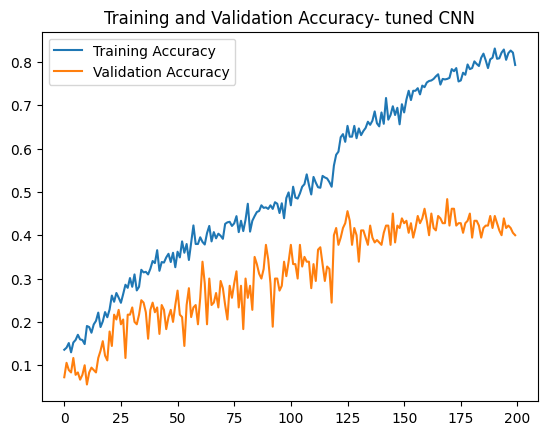

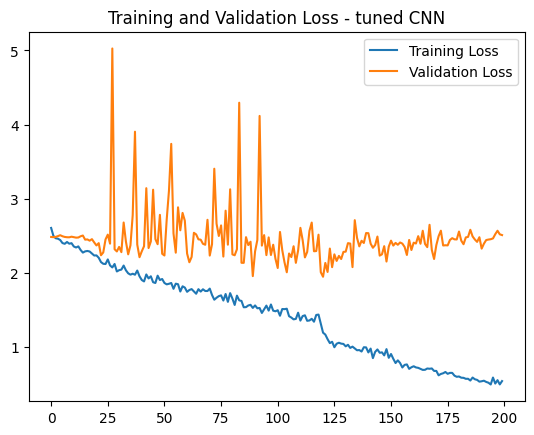

In [ ]:
# Plotting the learning curves
plt.plot(history_CNN.history['accuracy'], label='Training Accuracy')
plt.plot(history_CNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy- tuned CNN')
plt.legend()
plt.show()

plt.plot(history_CNN.history['loss'], label='Training Loss')
plt.plot(history_CNN.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - tuned CNN')
plt.legend()
plt.show()

## GRAPH FEEDBACK: **OVERFITTING AND NOT A GOOD FIT**

## Possible Reasons:
a. Insufficient Data to train ( 70 training samples for each category )

b. Category count - 12

c. Model Complexity - Too Small/Too Big

d. Add more number of epochs

e. Bad model architecture

## Tried out methodologies:
a. Hyperparamter Tuning

b. Increasing and Decreasing Model size

c. Adding Dropout layers and Residual blocks

d. Learning rate scheduling

In [ ]:
model1_cm,model1_accuracy = eval_model(tuned_model,test_dataset)

6/6 [==============================] - 0s 23ms/step - loss: 2.1319 - accuracy: 0.4333
Test Accuracy: 43.33%
6/6 [==============================] - 1s 19ms/step
Confusion Matrix:
[[ 6  0  3  0  0  1  0  2  0  1  0  2]
 [ 0 13  1  1  0  0  0  0  0  0  0  0]
 [ 1  2  2  2  1  2  0  1  0  0  0  4]
 [ 0  1  1  3  1  2  2  0  1  0  3  1]
 [ 2  0  0  3  5  0  0  0  4  0  0  1]
 [ 4  1  2  1  2  1  0  1  1  0  1  1]
 [ 2  0  0  1  1  0 10  0  0  0  0  1]
 [ 0  0  0  0  0  0  1 11  1  0  0  2]
 [ 1  1  0  1  4  1  0  1  4  2  0  0]
 [ 0  0  0  0  1  1  1  3  2  3  0  4]
 [ 0  0  0  1  0  0  0  1  0  1 12  0]
 [ 1  0  1  1  2  0  0  1  0  1  0  8]]


## MODEL 1 TEST ACCURACY - 43%




# **MODEL 2 - Mobilenet v3( TRANSFER LEARNING )**

## - No Data Augmentation
## - No EarlyStopping

In [ ]:
pretrained_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)
outputs = Dense(12, activation='softmax')(x)

model2_mobilenet = Model(inputs=inputs, outputs=outputs)
callbacks = [ tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Assignments/models/pest_detection_mobilenet", save_best_only=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)
]
model2_mobilenet.compile(
    optimizer=Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_mobilenet = model2_mobilenet.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset),
    epochs=50,
    callbacks= callbacks
)
model2_mobilenet.save('/content/drive/MyDrive/Assignments/models/mobilenet.h5')

Epoch 1/50
27/27 [==============================] - 22s 658ms/step - loss: 4.1666 - accuracy: 0.1429 - val_loss: 2.2839 - val_accuracy: 0.2833 - lr: 5.0000e-05
Epoch 2/50
27/27 [==============================] - 16s 610ms/step - loss: 2.2252 - accuracy: 0.3357 - val_loss: 1.6448 - val_accuracy: 0.4222 - lr: 5.0000e-05
Epoch 3/50
27/27 [==============================] - 20s 780ms/step - loss: 1.6895 - accuracy: 0.4548 - val_loss: 1.3608 - val_accuracy: 0.5111 - lr: 5.0000e-05
Epoch 4/50
27/27 [==============================] - 16s 603ms/step - loss: 1.4230 - accuracy: 0.5464 - val_loss: 1.1964 - val_accuracy: 0.6111 - lr: 5.0000e-05
Epoch 5/50
27/27 [==============================] - 16s 602ms/step - loss: 1.1865 - accuracy: 0.6357 - val_loss: 1.1007 - val_accuracy: 0.6333 - lr: 5.0000e-05
Epoch 6/50
27/27 [==============================] - 21s 812ms/step - loss: 0.9954 - accuracy: 0.6917 - val_loss: 1.0402 - val_accuracy: 0.6667 - lr: 5.0000e-05
Epoch 7/50
27/27 [======================

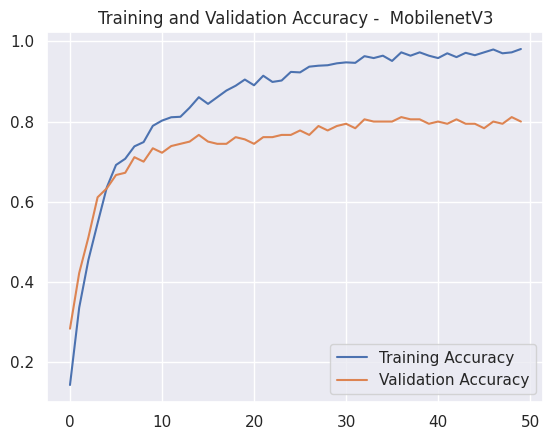

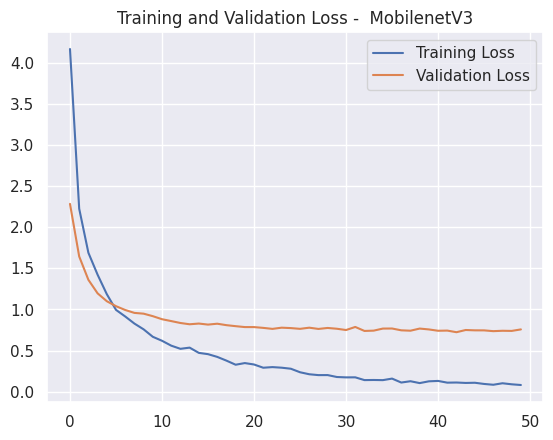

In [ ]:
# Plotting the learning curves
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy -  MobilenetV3')
plt.legend()
plt.show()

plt.plot(history_mobilenet.history['loss'], label='Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss -  MobilenetV3')
plt.legend()
plt.show()

## GRAPH FEEDBACK : **OVERFITTING**

In [ ]:
model2_cm,model2_accuracy = eval_model(model2_mobilenet,test_dataset)

6/6 [==============================] - 0s 17ms/step - loss: 0.5820 - accuracy: 0.8333
Test Accuracy: 83.33%
6/6 [==============================] - 1s 15ms/step
Confusion Matrix:
[[15  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  8  0  0  1  0  0  2  0  0  3]
 [ 0  0  1 11  1  0  1  1  0  0  0  0]
 [ 0  0  1  0  8  0  2  1  3  0  0  0]
 [ 0  0  1  0  0 13  0  0  1  0  0  0]
 [ 0  0  1  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0]
 [ 0  0  2  1  1  0  0  0  8  2  1  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0]
 [ 0  1  0  0  0  0  0  0  0  0 14  0]
 [ 0  0  1  0  0  0  0  0  0  0  0 14]]


In [ ]:
model2_report = generate_report(model2_mobilenet,test_dataset)
model2_report

6/6 [==============================] - 0s 13ms/step


,precision,recall,f1-score,support
ants,1.000000,1.000000,1.000000,15.000000
bees,0.882353,1.000000,0.937500,15.000000
beetle,0.533333,0.533333,0.533333,15.000000
catterpillar,0.916667,0.733333,0.814815,15.000000
earwig,0.800000,0.533333,0.640000,15.000000
grasshopper,0.928571,0.866667,0.896552,15.000000
earthworms,0.823529,0.933333,0.875000,15.000000
slug,0.882353,1.000000,0.937500,15.000000
moth,0.571429,0.533333,0.551724,15.000000
snail,0.882353,1.000000,0.937500,15.000000


# **MODEL 3 - EfficientNetV2 ( TRANSFER LEARNING )**




In [ ]:
def data_aug_effecientnet(x):
  augmentmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
  ])
  return augmentmentation_layer(x)

pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

473176280/473176280 [==============================] - 2s 0us/step


In [ ]:
inputs = pretrained_model.input
x = data_aug_effecientnet(inputs)
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True)
checkpoint= tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Assignments/models/pest_detection_eff", save_best_only=True)
outputs = Dense(12, activation='softmax')(x)
model3_eff = Model(inputs=inputs, outputs=outputs)
model3_eff.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_eff = model3_eff.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset),
    epochs=50,
    callbacks=[lr_scheduler,early_stopping]
)


Epoch 1/50
27/27 [==============================] - 50s 461ms/step - loss: 0.5581 - accuracy: 0.8238 - val_loss: 0.5937 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 4s 131ms/step - loss: 0.4630 - accuracy: 0.8655 - val_loss: 0.4977 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 3s 114ms/step - loss: 0.5831 - accuracy: 0.8333 - val_loss: 0.5209 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 3s 112ms/step - loss: 0.3823 - accuracy: 0.8774 - val_loss: 0.5429 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 4s 130ms/step - loss: 0.3389 - accuracy: 0.9012 - val_loss: 0.4444 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 4s 132ms/step - loss: 0.3332 - accuracy: 0.9012 - val_loss: 0.3973 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 3s 111ms/step - l

In [ ]:
model3_eff.save('/content/drive/MyDrive/Assignments/models/effnet.h5')

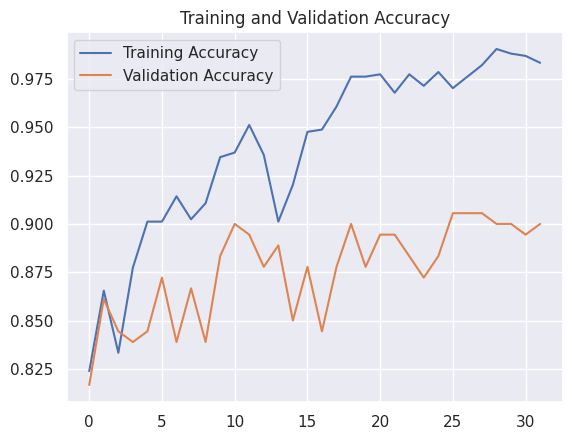

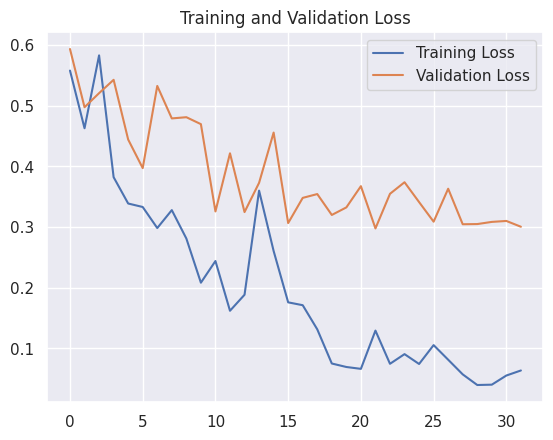

In [ ]:
# Plotting the learning curves
plt.plot(history_eff.history['accuracy'], label='Training Accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history_eff.history['loss'], label='Training Loss')
plt.plot(history_eff.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## GRAPH FEEDBACK : **SLIGHT OVERFITTING| EARLY STOPPING TRIGGERED AT 32nd EPOCH**

In [ ]:
print("Test Accuracy and Confusion Matrix  - EfficientNetV2 \n")
model3_cm,model3_accuracy = eval_model(model3_eff,test_dataset)


Test Accuracy and Confusion Matrix  - EfficientNetV2 

6/6 [==============================] - 1s 91ms/step - loss: 0.2655 - accuracy: 0.9222
Test Accuracy: 92.22%
6/6 [==============================] - 0s 81ms/step
Confusion Matrix:
[[15  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  1  1  1  0  0  0  2]
 [ 0  0  0 12  0  0  1  1  0  0  1  0]
 [ 0  0  0  1 13  0  1  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 14  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0]
 [ 0  0  1  0  0  0  0  0  0  0  0 14]]


6/6 [==============================] - 1s 85ms/step


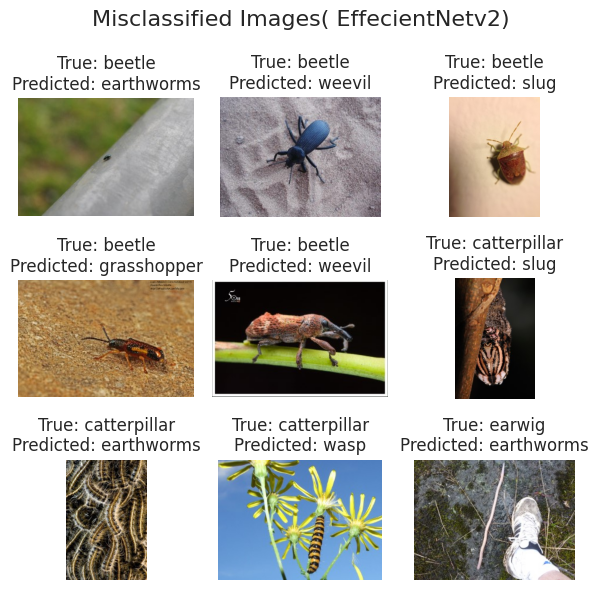

In [ ]:
predictions = model3_eff.predict(test_dataset)
predicted_class_indices = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_class_indices = np.argmax(true_labels, axis=1)
batch_size = 32
test_file_paths = []
for object_name in categories:
    object_dir = os.path.join('dataset', 'test', object_name)
    for file_name in os.listdir(object_dir):
        if file_name.lower().endswith('.jpg'):
            test_file_paths.append(os.path.join(object_dir, file_name))

test_file_paths.sort()
assert len(test_file_paths)+1 == len(predicted_class_indices)

misclassified_indices = np.where(predicted_class_indices != true_class_indices)[0]
class_names = np.array(categories)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))  # Adjust the figsize to better fit your screen if necessary
fig.suptitle('Misclassified Images( EffecientNetv2)', fontsize=16)

# Flattening the axes array for easier iteration
axes = axes.flatten()

# Loop over the first 10 misclassified indices
for idx, ax in zip(misclassified_indices[:9], axes):
    file_path = test_file_paths[idx]
    true_label_index = true_class_indices[idx]
    predicted_label_index = predicted_class_indices[idx]

    # Open and display the image
    img = Image.open(file_path)
    ax.imshow(img)
    ax.set_title(f"True: {class_names[true_label_index]}\nPredicted: {class_names[predicted_label_index]}")
    ax.axis('off')  # Hide axes

# Adjust layout to prevent overlap
plt.tight_layout()  # Adjust the rect parameters if the title overlaps with the top row of images
plt.show()

In [ ]:
final_report_eff = generate_report(model3_eff,test_dataset)
final_report_eff

6/6 [==============================] - 1s 86ms/step


,precision,recall,f1-score,support
ants,1.000000,1.000000,1.000000,15.000000
bees,1.000000,1.000000,1.000000,15.000000
beetle,0.909091,0.666667,0.769231,15.000000
catterpillar,0.923077,0.800000,0.857143,15.000000
earwig,0.928571,0.866667,0.896552,15.000000
grasshopper,0.933333,0.933333,0.933333,15.000000
earthworms,0.823529,0.933333,0.875000,15.000000
slug,0.833333,1.000000,0.909091,15.000000
moth,1.000000,0.933333,0.965517,15.000000
snail,1.000000,1.000000,1.000000,15.000000


##📊 Conclusion
## Our journey through the complex yet fascinating world of agricultural pest classification using deep learning has been both challenging and rewarding. 🏆

## Impactful Outcomes: Our models have demonstrated promising results in accurately classifying various pests, showcasing the potential to significantly aid in sustainable agriculture practices by reducing reliance on chemical pesticides and increasing crop yield.
## Learning and Growing: This project has not only improved our understanding of deep learning applications in real-world scenarios but also highlighted the importance of continuous learning and adaptation in AI technologies.
## Future Directions: Moving forward, we aim to explore more sophisticated models and data augmentation techniques, integrate additional data sources, and perhaps even deploy our models in a real-world agricultural setting to see them in action.
## Thank you for exploring this notebook with us! If you have insights, questions, or suggestions, please feel free to share. Your feedback is invaluable as we continue to improve and push the boundaries of what's possible with AI in agriculture. 🌾🚀